# Resume-Job Description Fit Analysis
## BAAI/bge-large-en-v1.5 + Standard LoRA with Stratified Sampling

This notebook evaluates resume-job matching using the BAAI/bge-large-en-v1.5 model fine-tuned with Standard LoRA on a stratified sample (default size: 20 pairs).

**Workflow:**
1. Load dataset and create stratified sample
2. Load BAAI/bge-large-en-v1.5 + Standard LoRA model
3. Generate match scores for resume-job pairs
4. Tune thresholds to optimize F1-score
5. Generate predictions and calculate evaluation metrics

## 1. Import Required Libraries

Import necessary libraries for data handling, model loading, embeddings generation, and evaluation metrics.

In [1]:
import pandas as pd
import numpy as np
import re
import subprocess
import sys
import time
from tqdm import tqdm

# Install required libraries
print("Installing required libraries...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "peft", "transformers", "torch", "tqdm"])
print("✓ Libraries installed successfully")

# ML and visualization libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning libraries
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
from peft import PeftModel

print("✓ All imports completed successfully")

Installing required libraries...
✓ Libraries installed successfully
✓ All imports completed successfully


## 2. Load and Prepare Dataset

Load the training dataset and display basic information about the data structure and class distribution.

In [2]:
# Load the training dataset
import os

# Determine the file path based on whether we're in Colab or local environment
#if os.path.exists('/content/drive/MyDrive'):
#    # Colab environment
#    csv_path = '/content/drive/MyDrive/AI-ML Self Learning/next_horizon/resume_job_recommendation/cnamuangtoun-resume-job-description-fit/train.csv'
#else:
#    # Local environment
#    csv_path = 'train.csv'
csv_path = 'train.csv'

df_train = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')

print("="*80)
print("DATASET INFORMATION")
print("="*80)
print(f"\nDataset shape: {df_train.shape}")
print(f"\nColumn types:\n{df_train.dtypes}")
print(f"\nFirst few rows:")
print(df_train.head())

print(f"\n\nClass Distribution:")
print(df_train['label'].value_counts())
print(f"\nClass Distribution (%):")
print(df_train['label'].value_counts(normalize=True) * 100)

DATASET INFORMATION

Dataset shape: (6241, 3)

Column types:
resume_text             object
job_description_text    object
label                   object
dtype: object

First few rows:
                                         resume_text  \
0  SummaryHighly motivated Sales Associate with e...   
1  Professional SummaryCurrently working with Cat...   
2  SummaryI started my construction career in Jun...   
3  SummaryCertified Electrical Foremanwith thirte...   
4  SummaryWith extensive experience in business/r...   

                                job_description_text   label  
0  Net2Source Inc. is an award-winning total work...  No Fit  
1  At Salas OBrien we tell our clients that were ...  No Fit  
2  Schweitzer Engineering Laboratories (SEL) Infr...  No Fit  
3  Mizick Miller & Company, Inc. is looking for a...  No Fit  
4  Life at Capgemini\nCapgemini supports all aspe...  No Fit  


Class Distribution:
label
No Fit           3143
Potential Fit    1556
Good Fit         1542
Name: 

## 3. Create Stratified Sample

Create a stratified random sample from the training dataset to maintain class distribution. Default sample size is 20 pairs.

In [3]:
# Configuration
SAMPLE_SIZE = 100  # Change this to adjust sample size

print("="*80)
print("CREATING STRATIFIED SAMPLE")
print("="*80)

# Get class counts and ratios
class_counts = df_train['label'].value_counts()
class_ratios = class_counts / len(df_train)

print(f"\nOriginal class distribution:")
for label, count in class_counts.items():
    pct = (count / len(df_train)) * 100
    print(f"  {label}: {count:5d} ({pct:5.1f}%)")

# Perform stratified sampling
df_sample = df_train.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=max(1, int(SAMPLE_SIZE * class_ratios[x.name])), random_state=42)
).copy()

# Adjust if we didn't get exactly SAMPLE_SIZE
if len(df_sample) < SAMPLE_SIZE:
    remaining = SAMPLE_SIZE - len(df_sample)
    extra_samples = df_train.drop(df_sample.index).sample(n=remaining, random_state=42)
    df_sample = pd.concat([df_sample, extra_samples])
elif len(df_sample) > SAMPLE_SIZE:
    df_sample = df_sample.sample(n=SAMPLE_SIZE, random_state=42)

print(f"\nStratified sample ({len(df_sample)} pairs):")
sample_counts = df_sample['label'].value_counts()
for label in class_counts.index:
    count = sample_counts.get(label, 0)
    pct = (count / len(df_sample)) * 100 if len(df_sample) > 0 else 0
    print(f"  {label}: {count:5d} ({pct:5.1f}%)")

print(f"\n✓ Stratified sample created with {len(df_sample)} pairs")

CREATING STRATIFIED SAMPLE

Original class distribution:
  No Fit:  3143 ( 50.4%)
  Potential Fit:  1556 ( 24.9%)
  Good Fit:  1542 ( 24.7%)

Stratified sample (100 pairs):
  No Fit:    51 ( 51.0%)
  Potential Fit:    24 ( 24.0%)
  Good Fit:    25 ( 25.0%)

✓ Stratified sample created with 100 pairs


/tmp/ipython-input-1118149893.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_train.groupby('label', group_keys=False).apply(


## 4. Load BAAI/bge-large-en-v1.5 + Standard LoRA Model

Load the base BAAI/bge-large-en-v1.5 model and apply the Standard LoRA adapter for resume-job matching.

In [4]:
print("="*80)
print("LOADING BAAI/bge-large-en-v1.5 + STANDARD LORA MODEL")
print("="*80 + "\n")

def load_standard_matcher():
    """Load standard LoRA-based resume-job matcher"""
    try:
        print("Loading base model: BAAI/bge-large-en-v1.5...")
        base_model = AutoModel.from_pretrained("BAAI/bge-large-en-v1.5")

        print("Loading LoRA adapter: shashu2325/resume-job-matcher-lora...")
        model = PeftModel.from_pretrained(base_model, "shashu2325/resume-job-matcher-lora")

        print("Loading tokenizer: BAAI/bge-large-en-v1.5...")
        tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-large-en-v1.5")

        model.eval()
        print("\n✓ Model loaded and set to evaluation mode")
        return model, tokenizer
    except Exception as e:
        print(f"✗ Error loading model: {str(e)}")
        return None, None

def get_lora_match_score(model, tokenizer, resume_text, job_text):
    """
    Get match score using LoRA model
    Returns a normalized score between 0 and 1
    """
    if model is None or tokenizer is None:
        return None

    resume_inputs = tokenizer(resume_text, return_tensors="pt", max_length=512,
                             padding="max_length", truncation=True)
    job_inputs = tokenizer(job_text, return_tensors="pt", max_length=512,
                          padding="max_length", truncation=True)

    with torch.no_grad():
        resume_outputs = model(**resume_inputs)
        job_outputs = model(**job_inputs)

        resume_emb = F.normalize(resume_outputs.last_hidden_state.mean(dim=1), p=2, dim=1)
        job_emb = F.normalize(job_outputs.last_hidden_state.mean(dim=1), p=2, dim=1)

        similarity = torch.sum(resume_emb * job_emb, dim=1)
        match_score = torch.sigmoid(similarity).item()

    return match_score

# Load the model
print("\nLoading model...")
model, tokenizer = load_standard_matcher()

if model and tokenizer:
    print("\n✓ Model successfully loaded")
else:
    print("\n✗ Failed to load model. Check your internet connection and Hugging Face credentials.")

LOADING BAAI/bge-large-en-v1.5 + STANDARD LORA MODEL


Loading model...
Loading base model: BAAI/bge-large-en-v1.5...


config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Loading LoRA adapter: shashu2325/resume-job-matcher-lora...


adapter_config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.74M [00:00<?, ?B/s]

Loading tokenizer: BAAI/bge-large-en-v1.5...


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]


✓ Model loaded and set to evaluation mode

✓ Model successfully loaded


## 5. Generate Match Scores

For each resume-job description pair in the stratified sample, generate embedding vectors and calculate match scores.

In [5]:
%%time
print("="*80)
print("GENERATING MATCH SCORES")
print("="*80 + "\n")

if model is None or tokenizer is None:
    print("✗ Model not loaded. Cannot generate scores.")
else:
    print(f"Computing match scores for {len(df_sample)} resume-job pairs...\n")

    match_scores = []
    start_time = time.time()

    for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Generating scores"):
        score = get_lora_match_score(model, tokenizer,
                                     row['resume_text'],
                                     row['job_description_text'])
        match_scores.append(score)

    df_sample['match_score'] = match_scores

    elapsed_time = time.time() - start_time

    print(f"\n✓ Generated match scores for {len(df_sample)} pairs")
    print(f"  Time elapsed: {elapsed_time:.2f} seconds")
    print(f"  Average time per pair: {(elapsed_time / len(df_sample) * 1000):.2f} ms")

    print(f"\n{'='*80}")
    print("MATCH SCORE STATISTICS")
    print(f"{'='*80}")
    print(f"  Min:    {df_sample['match_score'].min():.4f}")
    print(f"  Q1:     {df_sample['match_score'].quantile(0.25):.4f}")
    print(f"  Mean:   {df_sample['match_score'].mean():.4f}")
    print(f"  Median: {df_sample['match_score'].median():.4f}")
    print(f"  Q3:     {df_sample['match_score'].quantile(0.75):.4f}")
    print(f"  Max:    {df_sample['match_score'].max():.4f}")
    print(f"  Std:    {df_sample['match_score'].std():.4f}")

    # Show distribution by label
    print(f"\n{'='*80}")
    print("MATCH SCORE DISTRIBUTION BY ACTUAL LABEL")
    print(f"{'='*80}")

    for label in ['No Fit', 'Potential Fit', 'Good Fit']:
        label_scores = df_sample[df_sample['label'] == label]['match_score']
        if len(label_scores) > 0:
            print(f"\n{label} (n={len(label_scores)}:")
            print(f"  Mean:   {label_scores.mean():.4f}")
            print(f"  Median: {label_scores.median():.4f}")
            print(f"  Std:    {label_scores.std():.4f}")
            print(f"  Min:    {label_scores.min():.4f}")
            print(f"  Max:    {label_scores.max():.4f}")

GENERATING MATCH SCORES

Computing match scores for 100 resume-job pairs...



Generating scores: 100%|██████████| 100/100 [20:51<00:00, 12.51s/it]


✓ Generated match scores for 100 pairs
  Time elapsed: 1251.04 seconds
  Average time per pair: 12510.43 ms

MATCH SCORE STATISTICS
  Min:    0.4193
  Q1:     0.5568
  Mean:   0.5946
  Median: 0.5866
  Q3:     0.6567
  Max:    0.7243
  Std:    0.0799

MATCH SCORE DISTRIBUTION BY ACTUAL LABEL

No Fit (n=51:
  Mean:   0.5543
  Median: 0.5711
  Std:    0.0791
  Min:    0.4193
  Max:    0.7172

Potential Fit (n=24:
  Mean:   0.6323
  Median: 0.6263
  Std:    0.0572
  Min:    0.5218
  Max:    0.7237

Good Fit (n=25:
  Mean:   0.6406
  Median: 0.6392
  Std:    0.0557
  Min:    0.5412
  Max:    0.7243
CPU times: user 20min 16s, sys: 1.38 s, total: 20min 17s
Wall time: 20min 51s


## 6. Threshold Tuning

Test multiple threshold combinations to find optimal low and high thresholds that maximize F1-score.

In [6]:
def predict_fit_label(similarity_score, threshold_low=0.50, threshold_high=0.65):
    """
    Predict fit label based on match score and thresholds

    - score < threshold_low: "No Fit"
    - threshold_low <= score < threshold_high: "Potential Fit"
    - score >= threshold_high: "Good Fit"
    """
    if similarity_score < threshold_low:
        return "No Fit"
    elif similarity_score < threshold_high:
        return "Potential Fit"
    else:
        return "Good Fit"

print("="*80)
print("THRESHOLD TUNING")
print("="*80 + "\n")

results_tuning = []

# Test different threshold combinations
print("Testing threshold combinations...")
for low_threshold in [0.40, 0.45, 0.50, 0.55, 0.60]:
    for high_threshold in [low_threshold + 0.10, low_threshold + 0.15, low_threshold + 0.20]:
        # Predict with current thresholds
        predictions = df_sample['match_score'].apply(
            lambda x: predict_fit_label(x, threshold_low=low_threshold, threshold_high=high_threshold)
        )

        # Calculate metrics
        acc = accuracy_score(df_sample['label'], predictions)
        prec = precision_score(df_sample['label'], predictions, average='macro', zero_division=0)
        rec = recall_score(df_sample['label'], predictions, average='macro', zero_division=0)
        f1 = f1_score(df_sample['label'], predictions, average='macro', zero_division=0)

        results_tuning.append({
            'Low_Threshold': low_threshold,
            'High_Threshold': high_threshold,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1_Score': f1
        })

tuning_df = pd.DataFrame(results_tuning)
tuning_df = tuning_df.sort_values('F1_Score', ascending=False)

print(f"\nTop 10 Threshold Combinations (by F1-Score):")
print(tuning_df.head(10).to_string(index=False))

# Get best thresholds
best_row = tuning_df.iloc[0]
print(f"\n{'='*80}")
print("✓ BEST THRESHOLDS FOUND")
print(f"{'='*80}")
print(f"  Low Threshold:  {best_row['Low_Threshold']:.2f}")
print(f"  High Threshold: {best_row['High_Threshold']:.2f}")
print(f"  Accuracy:       {best_row['Accuracy']:.4f}")
print(f"  Precision:      {best_row['Precision']:.4f}")
print(f"  Recall:         {best_row['Recall']:.4f}")
print(f"  F1-Score:       {best_row['F1_Score']:.4f}")

THRESHOLD TUNING

Testing threshold combinations...

Top 10 Threshold Combinations (by F1-Score):
 Low_Threshold  High_Threshold  Accuracy  Precision   Recall  F1_Score
          0.60            0.70      0.57   0.510854 0.494216  0.487788
          0.55            0.65      0.47   0.533730 0.484902  0.463550
          0.55            0.70      0.46   0.554640 0.473791  0.438750
          0.60            0.75      0.56   0.360943 0.483660  0.406162
          0.60            0.80      0.56   0.360943 0.483660  0.406162
          0.50            0.65      0.40   0.550493 0.446503  0.403906
          0.50            0.60      0.40   0.531707 0.442614  0.397070
          0.50            0.70      0.39   0.573937 0.435392  0.379437
          0.55            0.75      0.45   0.406433 0.463235  0.348889
          0.45            0.65      0.31   0.538913 0.387680  0.307779

✓ BEST THRESHOLDS FOUND
  Low Threshold:  0.60
  High Threshold: 0.70
  Accuracy:       0.5700
  Precision:      0.5109


## 7. Generate Predictions with Optimized Thresholds

Apply the optimized thresholds to convert match scores into predicted fit labels.

In [7]:
# Apply optimized thresholds
best_low = best_row['Low_Threshold']
best_high = best_row['High_Threshold']

print("="*80)
print("GENERATING PREDICTIONS WITH OPTIMIZED THRESHOLDS")
print("="*80 + "\n")

df_sample['predicted_label'] = df_sample['match_score'].apply(
    lambda x: predict_fit_label(x, threshold_low=best_low, threshold_high=best_high)
)

print(f"Optimized Thresholds: Low={best_low:.2f}, High={best_high:.2f}\n")
print(f"Predicted Label Distribution:")
print(df_sample['predicted_label'].value_counts())
print(f"\nActual Label Distribution:")
print(df_sample['label'].value_counts())

# Show sample predictions
print(f"\n{'='*80}")
print("SAMPLE PREDICTIONS (First 10 rows)")
print(f"{'='*80}")
sample_display = df_sample[['resume_text', 'job_description_text', 'match_score',
                             'label', 'predicted_label']].head(10).copy()
sample_display['resume_text'] = sample_display['resume_text'].str[:40] + '...'
sample_display['job_description_text'] = sample_display['job_description_text'].str[:40] + '...'
print(sample_display.to_string(index=False))

GENERATING PREDICTIONS WITH OPTIMIZED THRESHOLDS

Optimized Thresholds: Low=0.60, High=0.70

Predicted Label Distribution:
predicted_label
No Fit           55
Potential Fit    32
Good Fit         13
Name: count, dtype: int64

Actual Label Distribution:
label
No Fit           51
Good Fit         25
Potential Fit    24
Name: count, dtype: int64

SAMPLE PREDICTIONS (First 10 rows)
                                resume_text                         job_description_text  match_score    label predicted_label
ProfileSecure a position with a well-est...  Hello, please look into the below mentio...     0.714697 Good Fit        Good Fit
Professional SummaryTransportation Logis...  Role - Business Analyst - Mobile Locatio...     0.556224 Good Fit          No Fit
Professional SummaryJr. Data Analyst wit...  Hello,Greetings from DevCare SolutionsI ...     0.541230 Good Fit          No Fit
SummaryElectronics technician and hardwa...  Our client is a growing Medical Device c...     0.668575 Good Fit 

## 8. Calculate Evaluation Metrics

Calculate accuracy, precision, recall, F1-score, and generate a confusion matrix and classification report.

In [8]:
print("="*80)
print("EVALUATION METRICS")
print("="*80 + "\n")

# Calculate metrics
accuracy = accuracy_score(df_sample['label'], df_sample['predicted_label'])
precision_macro = precision_score(df_sample['label'], df_sample['predicted_label'], average='macro', zero_division=0)
precision_weighted = precision_score(df_sample['label'], df_sample['predicted_label'], average='weighted', zero_division=0)
recall_macro = recall_score(df_sample['label'], df_sample['predicted_label'], average='macro', zero_division=0)
recall_weighted = recall_score(df_sample['label'], df_sample['predicted_label'], average='weighted', zero_division=0)
f1_macro = f1_score(df_sample['label'], df_sample['predicted_label'], average='macro', zero_division=0)
f1_weighted = f1_score(df_sample['label'], df_sample['predicted_label'], average='weighted', zero_division=0)

print(f"Accuracy:                {accuracy:.4f}")
print(f"Precision (Macro Avg):   {precision_macro:.4f}")
print(f"Precision (Weighted Avg):{precision_weighted:.4f}")
print(f"Recall (Macro Avg):      {recall_macro:.4f}")
print(f"Recall (Weighted Avg):   {recall_weighted:.4f}")
print(f"F1-Score (Macro Avg):    {f1_macro:.4f}")
print(f"F1-Score (Weighted Avg): {f1_weighted:.4f}")

print(f"\n{'='*80}")
print("CLASSIFICATION REPORT")
print(f"{'='*80}\n")
print(classification_report(df_sample['label'], df_sample['predicted_label'], zero_division=0))

# Confusion Matrix
print(f"\n{'='*80}")
print("CONFUSION MATRIX")
print(f"{'='*80}\n")
labels_list = ['No Fit', 'Potential Fit', 'Good Fit']
cm = confusion_matrix(df_sample['label'], df_sample['predicted_label'], labels=labels_list)
cm_df = pd.DataFrame(cm, index=labels_list, columns=labels_list)
print("Rows: Actual | Columns: Predicted\n")
print(cm_df)

EVALUATION METRICS

Accuracy:                0.5700
Precision (Macro Avg):   0.5109
Precision (Weighted Avg):0.5688
Recall (Macro Avg):      0.4942
Recall (Weighted Avg):   0.5700
F1-Score (Macro Avg):    0.4878
F1-Score (Weighted Avg): 0.5581

CLASSIFICATION REPORT

               precision    recall  f1-score   support

     Good Fit       0.46      0.24      0.32        25
       No Fit       0.73      0.78      0.75        51
Potential Fit       0.34      0.46      0.39        24

     accuracy                           0.57       100
    macro avg       0.51      0.49      0.49       100
 weighted avg       0.57      0.57      0.56       100


CONFUSION MATRIX

Rows: Actual | Columns: Predicted

               No Fit  Potential Fit  Good Fit
No Fit             40              9         2
Potential Fit       8             11         5
Good Fit            7             12         6


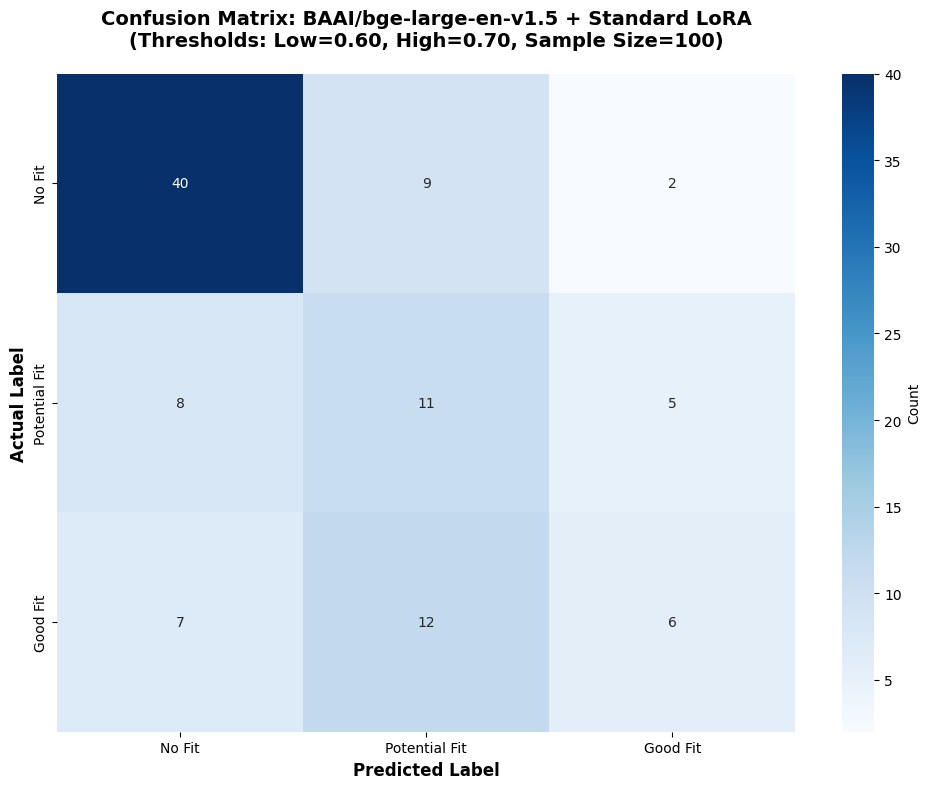

✓ Confusion matrix visualization displayed.


In [9]:
# Visualize Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, ax=ax)
ax.set_title('Confusion Matrix: BAAI/bge-large-en-v1.5 + Standard LoRA\n' +
             f'(Thresholds: Low={best_low:.2f}, High={best_high:.2f}, Sample Size={len(df_sample)})',
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Actual Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Confusion matrix visualization displayed.")

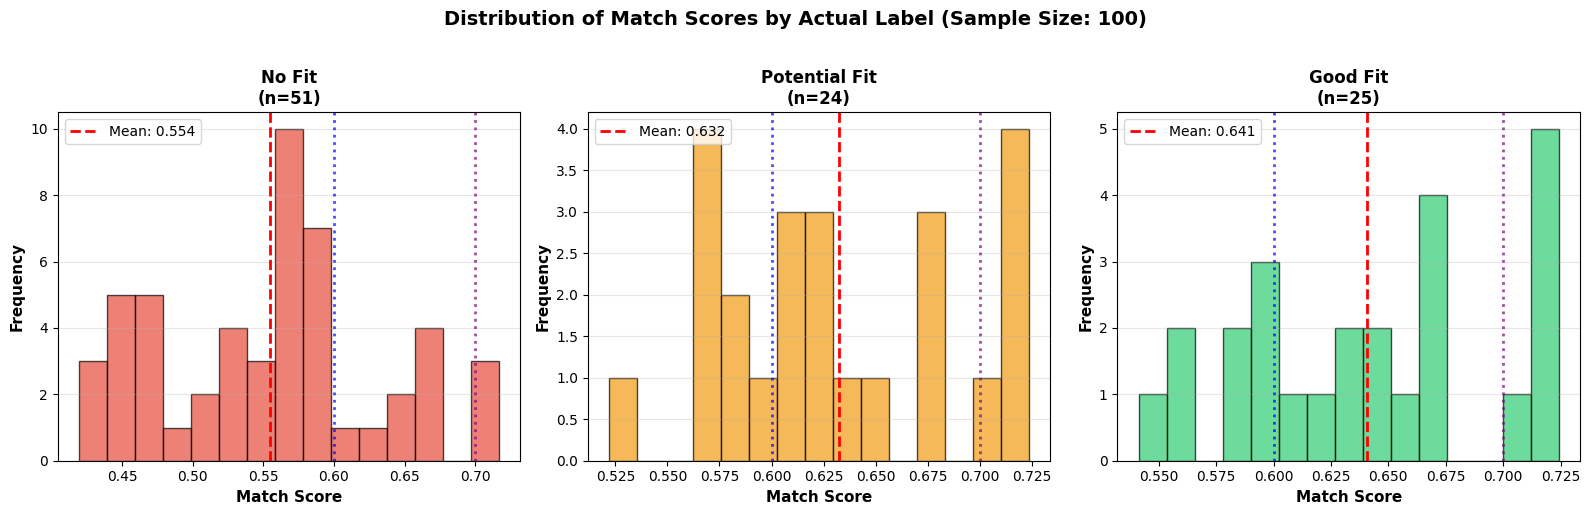

✓ Match score distribution visualization displayed.


In [10]:
# Visualize match score distribution by actual label
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

labels_list = ['No Fit', 'Potential Fit', 'Good Fit']
colors = ['#e74c3c', '#f39c12', '#2ecc71']

for ax, label, color in zip(axes, labels_list, colors):
    label_scores = df_sample[df_sample['label'] == label]['match_score']
    if len(label_scores) > 0:
        ax.hist(label_scores, bins=15, color=color, alpha=0.7, edgecolor='black')
        ax.axvline(label_scores.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {label_scores.mean():.3f}')
        ax.set_xlabel('Match Score', fontsize=11, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
        ax.set_title(f'{label}\n(n={len(label_scores)})', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

# Add threshold lines
for ax in axes:
    ax.axvline(best_low, color='blue', linestyle=':', linewidth=2, alpha=0.7, label='Low Threshold')
    ax.axvline(best_high, color='purple', linestyle=':', linewidth=2, alpha=0.7, label='High Threshold')

plt.suptitle(f'Distribution of Match Scores by Actual Label (Sample Size: {len(df_sample)})',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Match score distribution visualization displayed.")

In [11]:
# Summary and results
print("\n" + "="*80)
print("SUMMARY AND RESULTS")
print("="*80 + "\n")

print(f"STRATIFIED SAMPLE SIZE: {len(df_sample)} pairs")
print(f"\nOPTIMIZED THRESHOLDS:")
print(f"  Low Threshold:  {best_low:.2f}")
print(f"  High Threshold: {best_high:.2f}")

print(f"\nFINAL PERFORMANCE METRICS:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision_macro:.4f} (macro-averaged)")
print(f"  Recall:    {recall_macro:.4f} (macro-averaged)")
print(f"  F1-Score:  {f1_macro:.4f} (macro-averaged)")

if f1_macro > 0.50:
    print(f"\n✓ GOOD PERFORMANCE - F1-Score > 0.50")
elif f1_macro > 0.30:
    print(f"\n⚠ MODERATE PERFORMANCE - F1-Score > 0.30")
else:
    print(f"\n✗ NEEDS IMPROVEMENT - F1-Score < 0.30")

print(f"\nMODEL: BAAI/bge-large-en-v1.5 + Standard LoRA (shashu2325/resume-job-matcher-lora)")
print(f"DATASET: Resume-Job Description Matching")
print(f"EVALUATION: Stratified sampling with class distribution maintained")

print("\n" + "="*80)


SUMMARY AND RESULTS

STRATIFIED SAMPLE SIZE: 100 pairs

OPTIMIZED THRESHOLDS:
  Low Threshold:  0.60
  High Threshold: 0.70

FINAL PERFORMANCE METRICS:
  Accuracy:  0.5700
  Precision: 0.5109 (macro-averaged)
  Recall:    0.4942 (macro-averaged)
  F1-Score:  0.4878 (macro-averaged)

⚠ MODERATE PERFORMANCE - F1-Score > 0.30

MODEL: BAAI/bge-large-en-v1.5 + Standard LoRA (shashu2325/resume-job-matcher-lora)
DATASET: Resume-Job Description Matching
EVALUATION: Stratified sampling with class distribution maintained

